In [1]:
# Code to be used after the LULC bases have been created
# Determine the city bounding box, within which urban areas are classed as part of the city
# Determine the rural area extent to be used, which is proportional to the city area
# Determine the buffer zone area, which is based on the city outline

#import require packages
import pickle
import warnings
import scipy
from scipy import interpolate
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import earthpy as et
import numpy as np
import pandas as pd
import geopandas as gpd

#for creating buffer areas
from shapely.geometry import LineString
from shapely.ops import unary_union
#for finding the mode
from collections import Counter

#go to directory to work in 
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))

#load in csv of city lons and lats
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)

In [12]:
#### MANUAL ENTRIES ####

# Specify which city
CITY_COUNTRY = 'ANAPOLIS_BRAZIL'

# then load up LULC data for the city
with open('UHI_Project_Pickle_Files\LULC_Pickles\LULC_{}.pkl'.format(CITY_COUNTRY), 'rb') as f:
     LULC_df = pickle.load(f)   

# set the city name for the plots        
city_name = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY].City.values[0]

C:\Anaconda3\envs\project_environment\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Text(0, 0.5, 'y points')

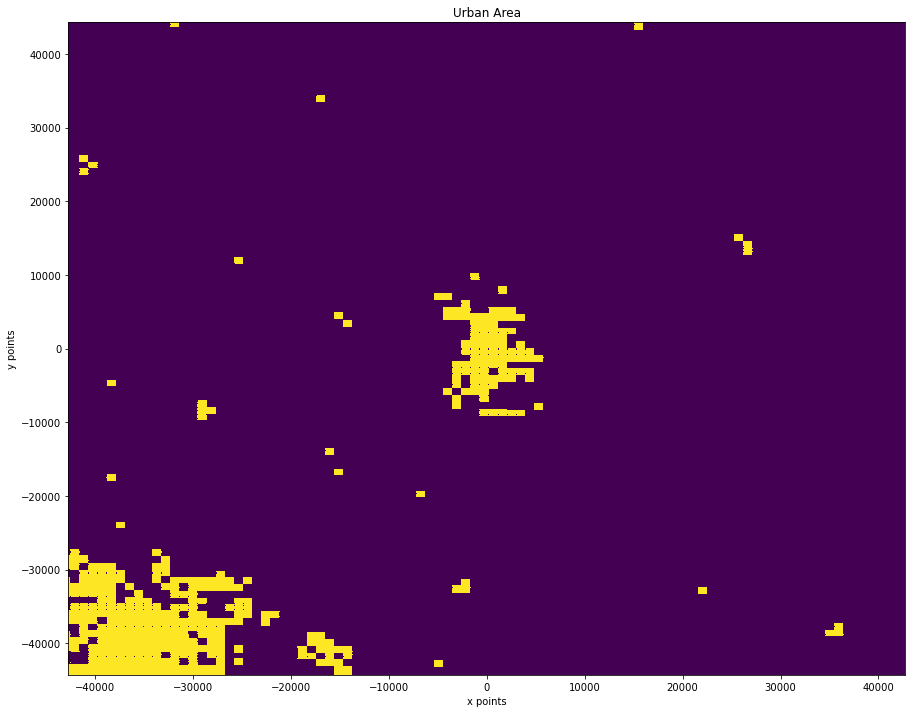

In [5]:
# Plot to look at city area to get bounding box
# get the points into the correct format

x_lu = LULC_df['x_points'].values
y_lu = LULC_df['y_points'].values
U_lu = LULC_df['is_urban_overall_2015'].values

X_lu, Y_lu = np.meshgrid(x_lu,y_lu)
Z_lu = scipy.interpolate.griddata((x_lu, y_lu), U_lu, (X_lu, Y_lu), method='nearest')

# inital plot
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (15,12))
axes.pcolormesh(X_lu, Y_lu, Z_lu, shading = 'auto')
axes.set_title('{} Urban Area'.format(city_name))
axes.set_xlabel('x points')
axes.set_ylabel('y points')

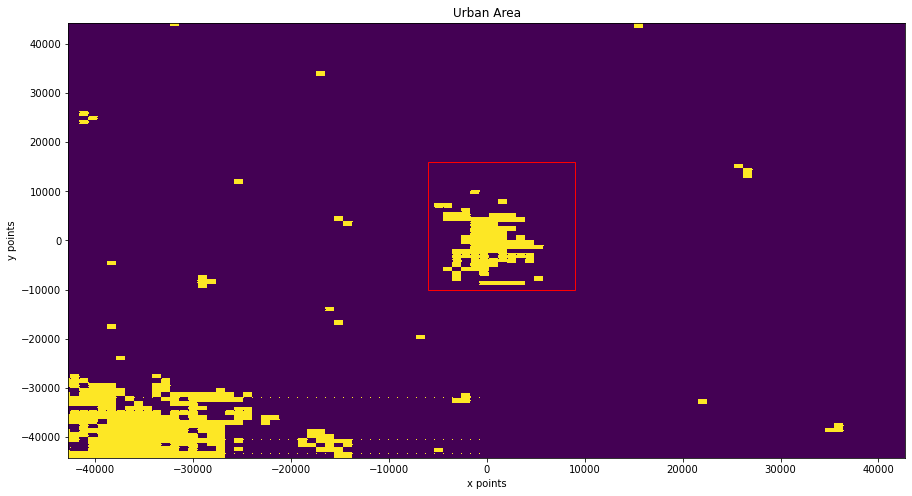

In [7]:
# Set bounding box and plot again

##### BOUNDING BOX ##### MANUAL ENTRY HERE #######
City_Bound_xmin =-6000
City_Bound_xmax = 9000
City_Bound_ymin = -10000
City_Bound_ymax = 16000
##################################################
box_height =  City_Bound_ymax - City_Bound_ymin
box_width = City_Bound_xmax - City_Bound_xmin
bbox = mpatches.Rectangle((City_Bound_xmin, City_Bound_ymin), box_width, box_height, angle = 0, 
                          linewidth=1,edgecolor='r',facecolor='none')

# inital plot
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (15,8))
axes.pcolormesh(X_lu, Y_lu, Z_lu, shading = 'auto')
axes.set_title('{} Urban Area'.format(city_name))
axes.set_xlabel('x points')
axes.set_ylabel('y points')
axes.add_patch(bbox)

In [14]:
# calculate the city area
City_area = LULC_df[((LULC_df['x_points'] > City_Bound_xmin) & (LULC_df['x_points'] < City_Bound_xmax) 
                             & (LULC_df['y_points'] > City_Bound_ymin) & (LULC_df['y_points'] < City_Bound_ymax))
                            ]['is_urban_overall_2015'].sum()

# add the new values into the city summary table
CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY) ,'City_Area'] = City_area
CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'City_Bound_xmin'] = City_Bound_xmin
CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'City_Bound_xmax'] = City_Bound_xmax
CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'City_Bound_ymin'] = City_Bound_ymin
CITY_COUNTRY_lat_lon.loc[(CITY_COUNTRY_lat_lon.CITY_COUNTRY == CITY_COUNTRY),'City_Bound_ymax'] = City_Bound_ymax

# determine where the edge of the city is, which is used to calculate city height & width
city_x_min = min(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['x_points'] > City_Bound_xmin)].x_points)
city_x_max = max(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['x_points'] < City_Bound_xmax)].x_points)
city_y_min = min(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['y_points'] > City_Bound_ymin)].y_points)
city_y_max = max(LULC_df[(LULC_df['is_urban_2015'] == 1) & (LULC_df['y_points'] < City_Bound_ymax)].y_points)

city_height = city_y_max - city_y_min
city_width = city_x_max - city_x_min

# calculate the cooridnate box that specifies the rural area to be used (based on 3 times the city)
max_lon_0 = LULC_df[LULC_df['x_points'] == (min(LULC_df[LULC_df['x_points'] >= 1.5*city_width].x_points))].Longitude.values[0]
min_lon_0 = LULC_df[LULC_df['x_points'] == (max(LULC_df[LULC_df['x_points'] <= -1.5*city_width].x_points))].Longitude.values[0]

max_lat_0 = LULC_df[LULC_df['y_points'] == (min(LULC_df[LULC_df['y_points'] >= 1.5*city_height].y_points))].Latitude.values[0]
min_lat_0 = LULC_df[LULC_df['y_points'] == (max(LULC_df[LULC_df['y_points'] <= -1.5*city_height].y_points))].Latitude.values[0]

# round up to 5 dps
if max_lon_0 > 0:
    max_lon = round((max_lon_0 + 0.000005),5)
else:
    max_lon = round((max_lon_0 - 0.000005),5)

if min_lon_0 > 0:
    min_lon = round((min_lon_0 - 0.000005),5)
else:
    min_lon = round((min_lon_0 + 0.000005),5)
        
if max_lat_0 > 0:    
    max_lat = round((max_lat_0 + 0.000005),5)
else:
    max_lat = round((max_lat_0 - 0.000005),5)
        
if min_lat_0 > 0:
    min_lat = round((min_lat_0 - 0.000005),5)
else:
    min_lat = round((min_lat_0 + 0.000005),5)

# add these to the table    
CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'max_lon'] = max_lon
CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'min_lon'] = min_lon
CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'max_lat'] = max_lat
CITY_COUNTRY_lat_lon.loc[CITY_COUNTRY_lat_lon['CITY_COUNTRY'] == CITY_COUNTRY, 'min_lat'] = min_lat

# crop the original LULC dataset so it is the calculated size
LULC_df_crop = LULC_df[((LULC_df.Latitude >= min_lat) & (LULC_df.Latitude <= max_lat) & (
    LULC_df.Longitude >= min_lon) & (LULC_df.Longitude <= max_lon))].copy()

Text(0, 0.5, 'y points')

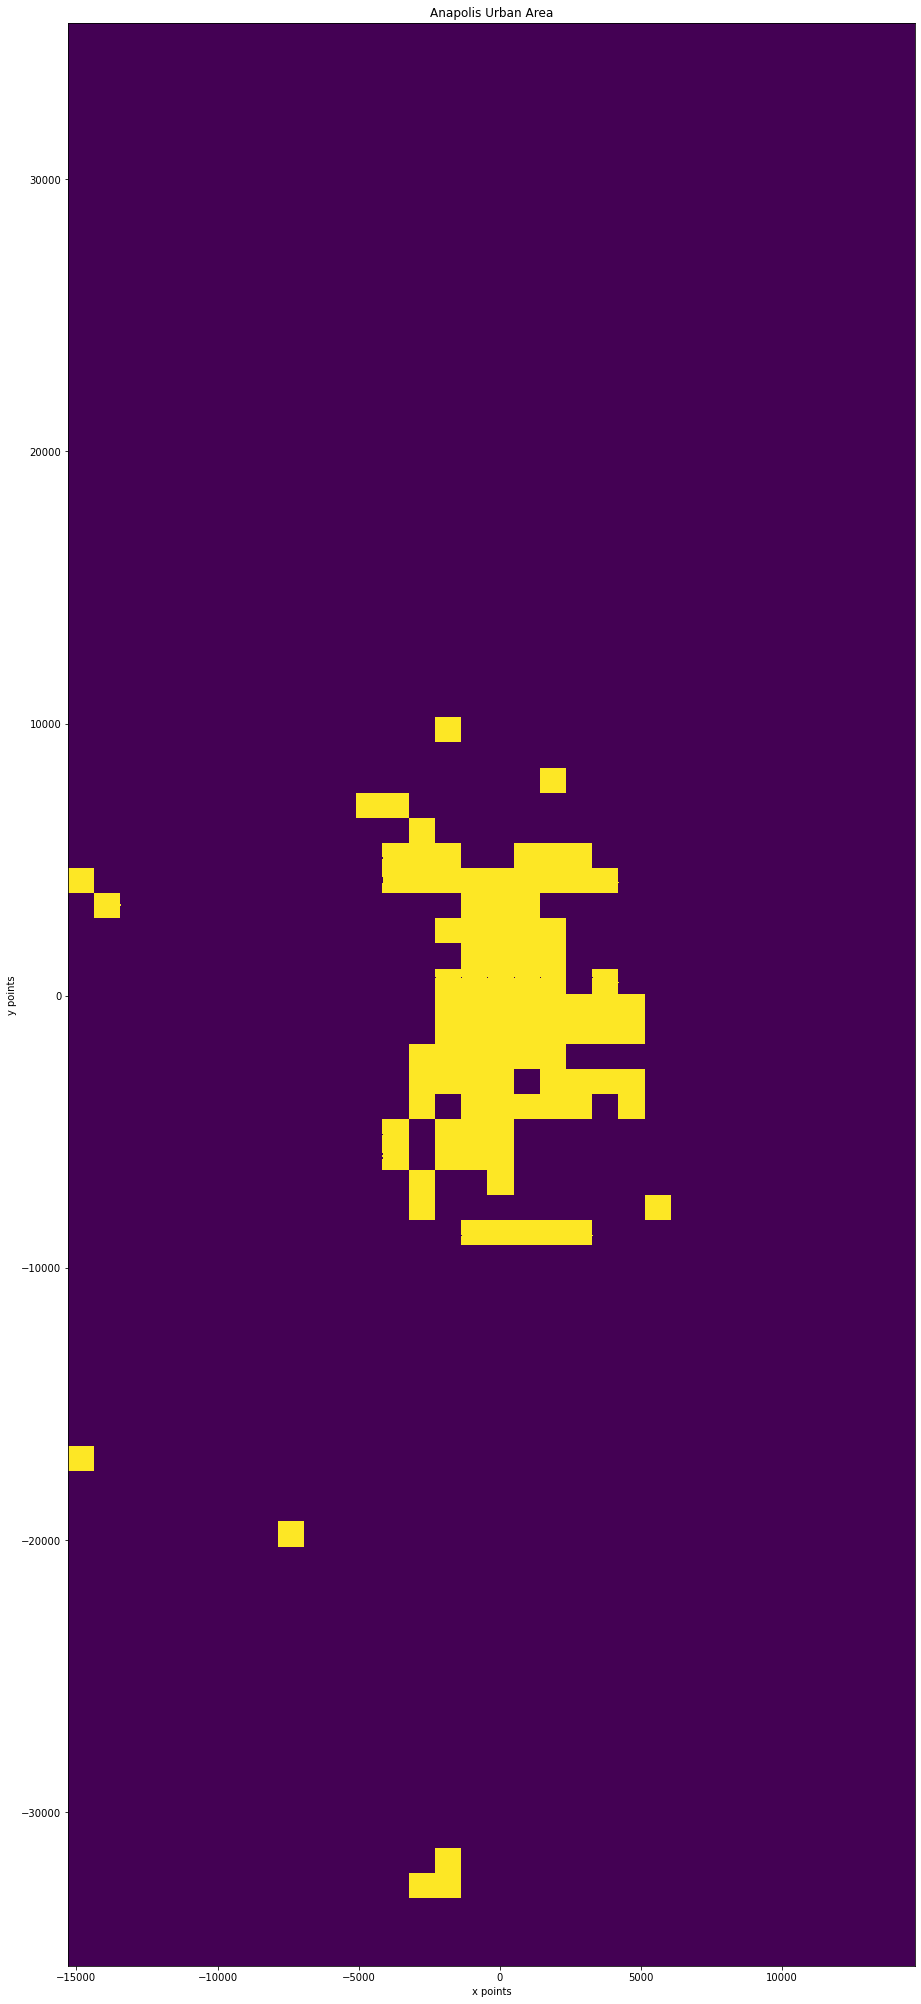

In [15]:
###############################################
####### OBSERVATION POINT #####################
###############################################

# Look at the cropped area

x = LULC_df_crop['x_points'].values
y = LULC_df_crop['y_points'].values
U = LULC_df_crop['is_urban_overall_2015'].values

X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), U, (X, Y), method='nearest')
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (max(x)/1000, max(y)/1000))
axes.pcolormesh(X, Y, Z, shading = 'auto')
axes.set_title('{} Urban Area'.format(city_name))
axes.set_xlabel('x points')
axes.set_ylabel('y points')

In [16]:
#Find a 5km buffer area
LULC_df_crop["buffer_radius"] = LULC_df_crop.geometry.buffer(5000)
city_points = LULC_df_crop[((LULC_df_crop['is_urban_2015'] == 1) & (LULC_df_crop['x_points'] > City_Bound_xmin)
               & (LULC_df_crop['x_points'] < City_Bound_xmax) & (LULC_df_crop['y_points'] > City_Bound_ymin)  
               & (LULC_df_crop['y_points'] < City_Bound_ymax))].copy()

#create overall buffer polygon
buffer_poly = unary_union(city_points.buffer_radius)

#add the buffer into the LULC dataset
point = LULC_df_crop.geometry
LULC_df_crop['buffer_zone'] = point.within(buffer_poly)
LULC_df_crop['buffer'] = 0
LULC_df_crop.loc[(LULC_df_crop['buffer_zone']) & (LULC_df_crop['is_urban_2015'] == 0),'buffer'] = 1


Text(0, 0.5, 'y points')

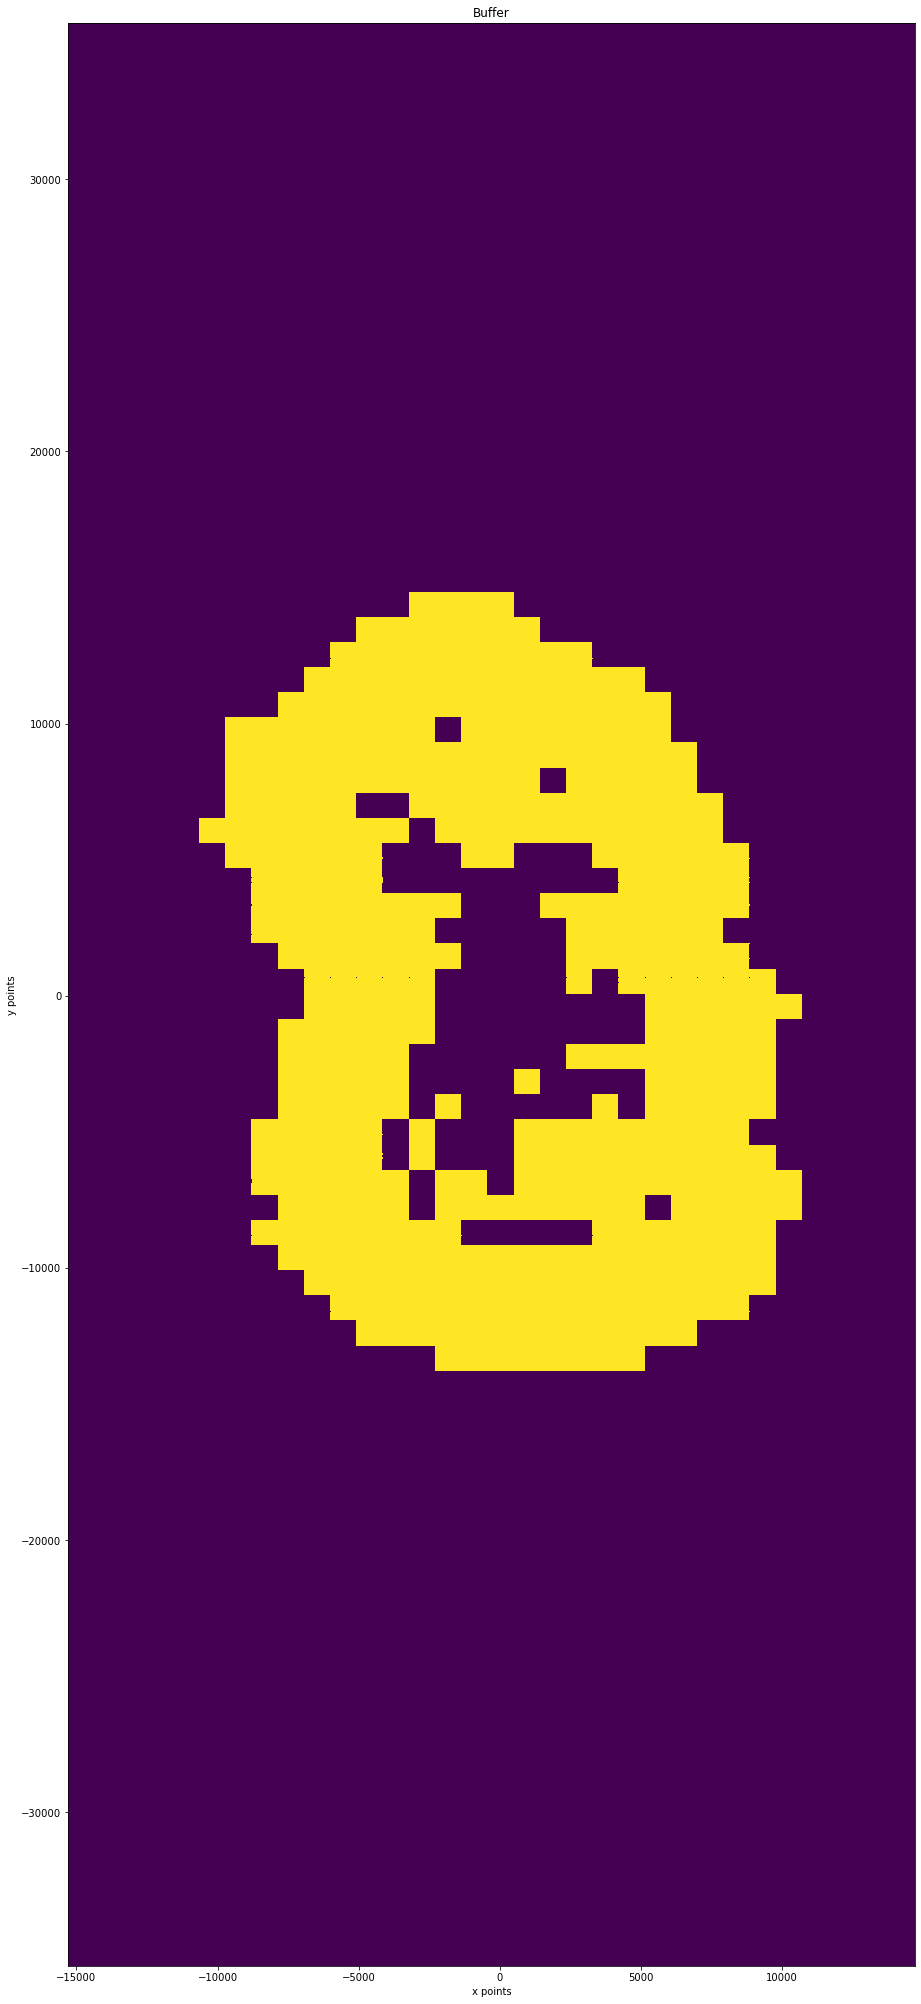

In [17]:
###############################################
####### OBSERVATION POINT #####################
###############################################

# look at buffer area

x = LULC_df_crop['x_points'].values
y = LULC_df_crop['y_points'].values
U = LULC_df_crop['buffer'].values

X,Y = np.meshgrid(x,y)
Z = scipy.interpolate.griddata((x, y), U, (X, Y), method='nearest')
fig, axes = plt.subplots(nrows=1, ncols = 1, figsize = (max(x)/1000, max(y)/1000))
axes.pcolormesh(X, Y, Z, shading = 'auto')
axes.set_title('Buffer')
axes.set_xlabel('x points')
axes.set_ylabel('y points')

In [ ]:
#determine the class for each pixel in the specified year
#5

lccs_class_overall_2000_list = []

for a in range(len(LULC_df_crop)):
    #get list of pixel classifications
    row = LULC_df_crop.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2000'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2000_list.append(mode[0])

#lccs_class_overall_2005
lccs_class_overall_2005_list = []

for a in range(len(LULC_df_crop)):
    #get list of pixel classifications
    row = LULC_df_crop.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2005'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2005_list.append(mode[0])

#lccs_class_overall_2010
lccs_class_overall_2010_list = []

for a in range(len(LULC_df_crop)):
    #get list of pixel classifications
    row = LULC_df_crop.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2010'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2010_list.append(mode[0])

#lccs_class_overall_2015
lccs_class_overall_2015_list = []

for a in range(len(LULC_df_crop)):
    #get list of pixel classifications
    row = LULC_df_crop.iloc[a]
    pixel_list = []

    for i in [1,2,3,4,5]: #the numbers for the 5 pixels
        pixel_name = 'lccs_class_{}_2015'.format(i)
        x = row[pixel_name]
        pixel_list.append(x)
    #find the mode of the list
    counter = Counter(pixel_list)
    max_count = max(counter.values())
    mode = [k for k,v in counter.items() if v == max_count]    #use the most common pixel classification. 
                                                                #if are equal numbers, the one assigned to nearer pixel is used
    lccs_class_overall_2015_list.append(mode[0])
    
    
#add the classifications back into the LULC_df
LULC_df_crop['lccs_class_overall_2000'] = lccs_class_overall_2000_list
LULC_df_crop['lccs_class_overall_2005'] = lccs_class_overall_2005_list
LULC_df_crop['lccs_class_overall_2010'] = lccs_class_overall_2010_list
LULC_df_crop['lccs_class_overall_2015'] = lccs_class_overall_2015_list

#save the new LULC dataframes as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files', 
                      'LULC_Pickles', 'Crop_wbuffer_LULC'))
pickle_name = 'LULC_{}.pkl'.format(CITY_COUNTRY)
with open(pickle_name, 'wb') as f:
    pickle.dump(LULC_df_crop, f)
    
#save the updates to the city info table
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon.to_excel('CITY_COUNTRY_lat_lon.xlsx', index = False)